## 1.Setup & Imports

In [1]:
import os
import warnings
import timeit
import multiprocessing as mp
import numpy as np
import pandas as pd
import librosa, librosa.display
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.utils import shuffle
from joblib import Parallel, delayed
import pickle

import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import (
    Conv1D, MaxPooling1D, BatchNormalization, Dropout,
    Flatten, Dense
)
from tensorflow.keras.callbacks import (
    ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, Callback
)

warnings.simplefilter("ignore")
print("CPUs available:", mp.cpu_count())


CPUs available: 12


In [2]:
# ── Cell 1: Install & configure Kaggle API ────────────────────────────────────
!pip install --quiet kaggle
from google.colab import files
files.upload()

!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


Saving kaggle.json to kaggle.json


In [3]:
# ── Cell 2: Create directory structure ───────────────────────────────────────
DATA_ROOT = "/content/data"
!mkdir -p /content/data/ravdess /content/data/crema /content/data/tess /content/data/savee


In [4]:
# ── Cell 3: Download & unzip each dataset ───────────────────────────────────

# RAVDESS
!kaggle datasets download -d uwrfkaggler/ravdess-emotional-speech-audio \
  -p $DATA_ROOT/ravdess --unzip

# CREMA-D
!kaggle datasets download -d ejlok1/cremad \
  -p $DATA_ROOT/crema --unzip

# TESS
!kaggle datasets download -d ejlok1/toronto-emotional-speech-set-tess \
  -p $DATA_ROOT/tess --unzip

# SAVEE
!kaggle datasets download -d ejlok1/surrey-audiovisual-expressed-emotion-savee \
  -p $DATA_ROOT/savee --unzip


Dataset URL: https://www.kaggle.com/datasets/uwrfkaggler/ravdess-emotional-speech-audio
License(s): CC-BY-NC-SA-4.0
 86% 368M/429M [00:00<00:00, 1.30GB/s]
100% 429M/429M [00:00<00:00, 1.29GB/s]
Dataset URL: https://www.kaggle.com/datasets/ejlok1/cremad
License(s): ODC Attribution License (ODC-By)
 87% 393M/451M [00:00<00:00, 1.36GB/s]
100% 451M/451M [00:00<00:00, 1.35GB/s]
Dataset URL: https://www.kaggle.com/datasets/ejlok1/toronto-emotional-speech-set-tess
License(s): Attribution-NonCommercial-NoDerivatives 4.0 International (CC BY-NC-ND 4.0)
 87% 371M/428M [00:00<00:00, 1.32GB/s]
100% 428M/428M [00:00<00:00, 1.30GB/s]
Dataset URL: https://www.kaggle.com/datasets/ejlok1/surrey-audiovisual-expressed-emotion-savee
License(s): copyright-authors
  0% 0.00/107M [00:00<?, ?B/s]
100% 107M/107M [00:00<00:00, 1.28GB/s]


## 2.Paths to audio datasets

In [5]:
# ── Cell 4: Define paths & loaders ───────────────────────────────────────────
import os
import pandas as pd

# 1. Paths (reflect Colab unzip structure)
DATA_ROOT    = "/content/data"
ravdess_path = os.path.join(DATA_ROOT, "ravdess", "audio_speech_actors_01-24")
crema_path   = os.path.join(DATA_ROOT, "crema",   "AudioWAV")
tess_path    = os.path.join(DATA_ROOT, "tess",    "TESS Toronto emotional speech set data")
savee_path   = os.path.join(DATA_ROOT, "savee",   "ALL")


## 3.Load & parse each dataset

In [6]:

def load_dataset(base_path, parser):
    records = []
    for entry in os.listdir(base_path):
        records.extend(parser(base_path, entry))
    return pd.DataFrame(records)

def parse_ravdess(base, actor):
    recs = []
    dirpath = os.path.join(base, actor)
    for fname in os.listdir(dirpath):
        code = fname.split('-')[2]
        label = {
            '01':'neutral','02':'calm','03':'happy','04':'sad',
            '05':'angry','06':'fearful','07':'disgust','08':'surprised'
        }[code].lower()
        recs.append({'Path': os.path.join(dirpath, fname), 'Emotion': label})
    return recs

def parse_crema(base, fname):
    lab = fname.split('_')[2]
    label = {'SAD':'sad','ANG':'angry','DIS':'disgust',
             'FEA':'fearful','HAP':'happy','NEU':'neutral'}.get(lab, 'unknown').lower()
    return [{'Path': os.path.join(base, fname), 'Emotion': label}]

def parse_tess(base, actor):
    recs = []
    dirpath = os.path.join(base, actor)
    for fname in os.listdir(dirpath):
        lab = fname.split('_')[2].lower()
        label = 'surprised' if lab=='ps' else lab
        recs.append({'Path': os.path.join(dirpath, fname), 'Emotion': label})
    return recs

def parse_savee(base, fname):
    ele = fname.split('_')[1][:-6]
    label = {'a':'angry','d':'disgust','f':'fearful',
             'h':'happy','n':'neutral','sa':'sad'}.get(ele, 'surprised')
    return [{'Path': os.path.join(base, fname), 'Emotion': label}]

# Load into DataFrames
ravdess_df = load_dataset(ravdess_path, parse_ravdess)
crema_df   = load_dataset(crema_path, parse_crema)
tess_df    = load_dataset(tess_path, parse_tess)
savee_df   = load_dataset(savee_path, parse_savee)

# 5. Quick sanity check
print("RAVDESS:", ravdess_df.shape)
print("CREMA-D:", crema_df.shape)
print("TESS:", tess_df.shape)
print("SAVEE:", savee_df.shape)


RAVDESS: (1440, 2)
CREMA-D: (7442, 2)
TESS: (2800, 2)
SAVEE: (480, 2)


## 4.Combine, Clean & Inspect (Raw Data Counts)

Total samples: 12162


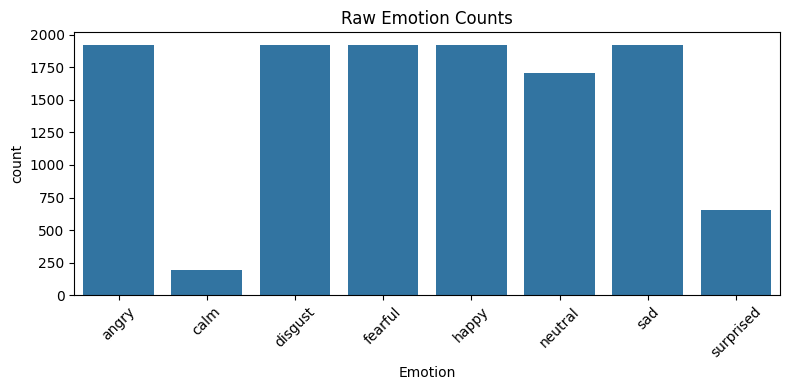

In [7]:
# Cell 4 – Combine, Clean & Inspect (Raw Data Counts)
# 3. Combine, clean & inspect
data_path = pd.concat([ravdess_df, crema_df, tess_df, savee_df], ignore_index=True)
data_path['Emotion'] = data_path['Emotion'].str.replace(r"\.wav$", "", regex=True)
data_path['Emotion'] = data_path['Emotion'].replace({
    'fear':'fearful','ps':'surprised','pleasantsurprise':'surprised'
})
data_path = shuffle(data_path, random_state=42).reset_index(drop=True)

print("Total samples:", len(data_path))
plt.figure(figsize=(8,4))
sns.countplot(x='Emotion', data=data_path, order=sorted(data_path.Emotion.unique()))
plt.title("Raw Emotion Counts")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


## 5.Raw-Audio Exploration & Visualization

In [8]:
sample_idx = 0
sample_path = data_path.Path.iloc[sample_idx]
y, sr = librosa.load(sample_path, duration=2.5, offset=0.6)
emotion = data_path.Emotion.iloc[sample_idx].title()

### 5.1.Waveform

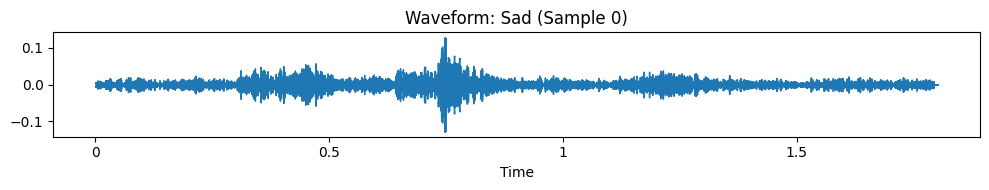

In [9]:
plt.figure(figsize=(10,2))
librosa.display.waveshow(y, sr=sr)
plt.title(f"Waveform: {emotion} (Sample {sample_idx})")
plt.tight_layout()
plt.show()

### 5.2.Mel-Spectrogram

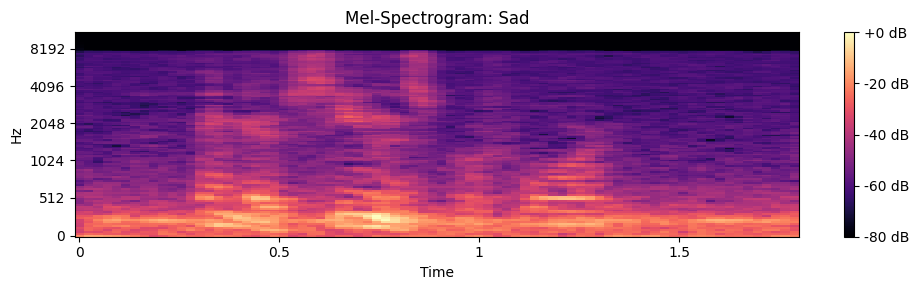

In [10]:
plt.figure(figsize=(10,3))
S = librosa.feature.melspectrogram(y=y, sr=sr)
librosa.display.specshow(librosa.power_to_db(S, ref=np.max),
                         sr=sr, x_axis='time', y_axis='mel')
plt.title(f"Mel-Spectrogram: {emotion}")
plt.colorbar(format='%+2.0f dB')
plt.tight_layout()
plt.show()

## 5.3.MFCCs

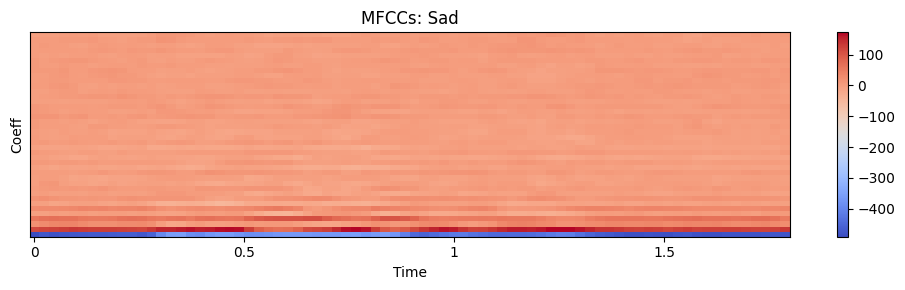

In [11]:
mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=40)
plt.figure(figsize=(10,3))
librosa.display.specshow(mfcc, sr=sr, x_axis='time')
plt.title(f"MFCCs: {emotion}")
plt.ylabel("Coeff")
plt.colorbar()
plt.tight_layout()
plt.show()

## 6.Data Augmentation Functions

In [12]:
# Cell 6 – Data Augmentation Functions
# 4. Augmentation functions
def add_noise(x): return x + 0.035*np.random.uniform()*np.amax(x)*np.random.normal(size=x.shape)
def stretch(x, rate=0.8): return librosa.effects.time_stretch(y=x, rate=rate)
def shift(x): return np.roll(x, int(np.random.uniform(-5,5)*1000))
def pitch(x, sr, n_steps=0.7): return librosa.effects.pitch_shift(y=x, sr=sr, n_steps=n_steps)


## 7.Feature Extraction Definitions

In [13]:
# Cell 7 – Feature Extraction Definitions
# 5. Fixed-length feature extractor
n_mfcc, max_frames = 40, 100
def pad_truncate(feat, max_len):
    return (np.pad(feat, ((0,0),(0,max_len-feat.shape[1])), mode='constant')
            if feat.shape[1]<max_len else feat[:,:max_len])

def extract_features_fixed(y, sr):
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc)
    mfcc = pad_truncate(mfcc, max_frames)
    mfcc = (mfcc - mfcc.mean())/(mfcc.std()+1e-6)
    z = pad_truncate(librosa.feature.zero_crossing_rate(y=y), max_frames)
    r = pad_truncate(librosa.feature.rms(y=y), max_frames)
    stacked = np.vstack((mfcc, z, r))
    return stacked.flatten()

def get_features(path):
    y, sr = librosa.load(path, duration=2.5, offset=0.6)
    out = [extract_features_fixed(y, sr)]
    for fn in (add_noise, lambda x: stretch(x,0.8), shift, lambda x: pitch(x, sr, 0.7)):
        out.append(extract_features_fixed(fn(y), sr))
    return np.stack(out, axis=0)


## 8.Bulk Feature Extraction (Parallel)

In [14]:
# 6. Parallel feature computation
start = timeit.default_timer()
results = Parallel(n_jobs=-1)(delayed(get_features)(p) for p in data_path.Path)
print("Feature extraction time:", timeit.default_timer() - start)


Feature extraction time: 172.28792838000027


## 9.Post-Extraction Feature Arrays

In [15]:
# Cell 9 – Post-Extraction Feature Arrays
# 7. Assemble X, Y
X, Y = [], []
for feats, emo in zip(results, data_path.Emotion):
    for vec in feats:
        X.append(vec)
        Y.append(emo)
X = np.vstack(X)
Y = np.array(Y)
print("Feature array shape:", X.shape)


Feature array shape: (60810, 4200)


## 10.Feature-Value Distribution

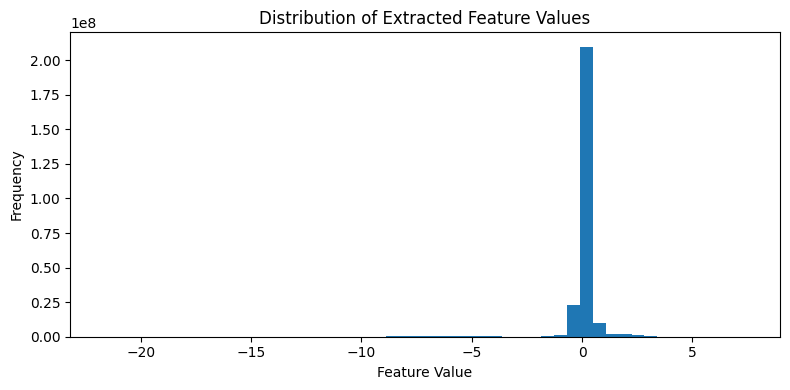

In [16]:
# Cell 10 – Feature-Value Distribution
plt.figure(figsize=(8,4))
plt.hist(X.flatten(), bins=50)
plt.title("Distribution of Extracted Feature Values")
plt.xlabel("Feature Value")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()


## 11.Feature-Space Visualization (PCA & t-SNE)

In [17]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

## 11.1.PCA to 2D

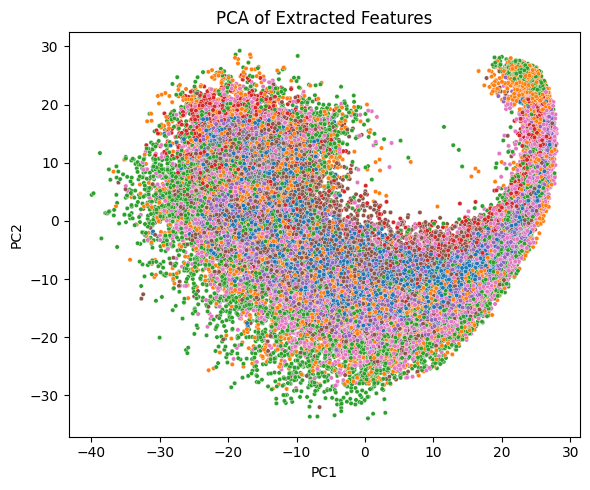

In [18]:
pca = PCA(n_components=2).fit_transform(X)
plt.figure(figsize=(6,5))
sns.scatterplot(x=pca[:,0], y=pca[:,1], hue=Y, palette='tab10', s=10, legend=False)
plt.title("PCA of Extracted Features")
plt.xlabel("PC1"); plt.ylabel("PC2"); plt.tight_layout()
plt.show()

## 11.2.t-SNE (subsample)

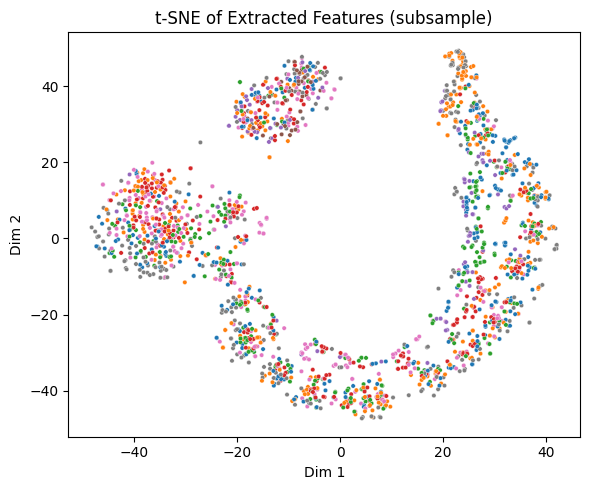

In [19]:
sample_ix = np.random.choice(len(X), size=2000, replace=False)
tsne = TSNE(n_components=2, init='pca', learning_rate='auto').fit_transform(X[sample_ix])
plt.figure(figsize=(6,5))
sns.scatterplot(x=tsne[:,0], y=tsne[:,1], hue=Y[sample_ix], palette='tab10', s=10, legend=False)
plt.title("t-SNE of Extracted Features (subsample)")
plt.xlabel("Dim 1"); plt.ylabel("Dim 2"); plt.tight_layout()
plt.show()

## 12.Preprocess & Split into Train/Val/Test (90/5/5)

In [20]:

scaler  = StandardScaler().fit(X)
X_scaled = scaler.transform(X)

encoder = OneHotEncoder(sparse_output=False).fit(Y.reshape(-1,1))
Y_enc = encoder.transform(Y.reshape(-1,1))


## 12.1.Split off 90% train vs. 10% hold-out

In [21]:
x_train, x_hold, y_train, y_hold = train_test_split(
    X_scaled, Y_enc,
    test_size=0.10,
    random_state=42,
    stratify=np.argmax(Y_enc, axis=1)
)

## 12.2.Split hold-out 10% into 50/50 val & test

In [22]:
#split hold-out 10% into 50/50 val & test (≈5% each)
x_val, x_test, y_val, y_test = train_test_split(
    x_hold, y_hold,
    test_size=0.50,
    random_state=42,
    stratify=np.argmax(y_hold, axis=1)
)

## 12.3. Reshape for Conv1D

In [23]:
x_tr_cnn  = x_train[..., np.newaxis]
x_val_cnn = x_val[...,   np.newaxis]
x_te_cnn  = x_test[...,  np.newaxis]
print("Train / Val / Test shapes:", x_tr_cnn.shape, x_val_cnn.shape, x_te_cnn.shape)

Train / Val / Test shapes: (54729, 4200, 1) (3040, 4200, 1) (3041, 4200, 1)


## 13. Epoch-Detail Logger Callback

In [24]:
class EpochDetailLogger(Callback):
    def on_epoch_end(self, epoch, logs=None):
        l = logs or {}
        print(f"Epoch {epoch+1} → loss: {l['loss']:.4f}, acc: {l['accuracy']:.4f}, "
              f"val_loss: {l['val_loss']:.4f}, val_acc: {l['val_accuracy']:.4f}")

## 14. Model Definition & Compile

In [25]:
# Cell 14 – Model Definition & Compile
model = Sequential([
    Conv1D(512, 5, padding='same', activation='relu', input_shape=x_tr_cnn.shape[1:]),
    BatchNormalization(),
    MaxPooling1D(5,2,'same'),
    Dropout(0.3),

    Conv1D(512, 5, padding='same', activation='relu'),
    BatchNormalization(),
    MaxPooling1D(5,2,'same'),
    Dropout(0.4),

    Conv1D(256, 5, padding='same', activation='relu'),
    BatchNormalization(),
    MaxPooling1D(5,2,'same'),

    Conv1D(256, 3, padding='same', activation='relu'),
    BatchNormalization(),
    MaxPooling1D(5,2,'same'),
    Dropout(0.4),

    Conv1D(128, 3, padding='same', activation='relu'),
    BatchNormalization(),
    MaxPooling1D(3,2,'same'),
    Dropout(0.5),

    Flatten(),

    Dense(512, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),

    Dense(Y_enc.shape[1], activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


## 15. Training

In [26]:
class DelayedEarlyStopping(EarlyStopping):
    def __init__(self, start_epoch=40, **kwargs):
        super().__init__(**kwargs)
        self.start_epoch = start_epoch

    def on_epoch_end(self, epoch, logs=None):
        if epoch >= self.start_epoch:
            super().on_epoch_end(epoch, logs)

callbacks = [
    ModelCheckpoint('best_model.keras', monitor='val_accuracy', save_best_only=True),
    DelayedEarlyStopping(
        start_epoch=40,
        monitor='val_accuracy',
        patience=5,
        restore_best_weights=True,
        verbose=1
    ),
    ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=3),
    EpochDetailLogger()
]


history = model.fit(
    x_tr_cnn, y_train,
    validation_data=(x_val_cnn, y_val),
    epochs=100, batch_size=64,
    callbacks=callbacks,
    verbose=0
)

Epoch 1 → loss: 1.3035, acc: 0.5469, val_loss: 0.9302, val_acc: 0.6447
Epoch 2 → loss: 0.9385, acc: 0.6474, val_loss: 0.8213, val_acc: 0.7000
Epoch 3 → loss: 0.8334, acc: 0.6843, val_loss: 0.7232, val_acc: 0.7293
Epoch 4 → loss: 0.7582, acc: 0.7156, val_loss: 0.8073, val_acc: 0.6908
Epoch 5 → loss: 0.7586, acc: 0.7142, val_loss: 0.5982, val_acc: 0.7803
Epoch 6 → loss: 0.6375, acc: 0.7600, val_loss: 0.5522, val_acc: 0.7918
Epoch 7 → loss: 0.5898, acc: 0.7785, val_loss: 0.4947, val_acc: 0.8158
Epoch 8 → loss: 0.5262, acc: 0.8047, val_loss: 0.4907, val_acc: 0.8299
Epoch 9 → loss: 0.4771, acc: 0.8221, val_loss: 0.4053, val_acc: 0.8480
Epoch 10 → loss: 0.4368, acc: 0.8383, val_loss: 0.4038, val_acc: 0.8533
Epoch 11 → loss: 0.4002, acc: 0.8522, val_loss: 0.4099, val_acc: 0.8530
Epoch 12 → loss: 0.3703, acc: 0.8637, val_loss: 0.3234, val_acc: 0.8809
Epoch 13 → loss: 0.3420, acc: 0.8749, val_loss: 0.3020, val_acc: 0.8931
Epoch 14 → loss: 0.3177, acc: 0.8827, val_loss: 0.3072, val_acc: 0.8944
E

## 16. Save Training History

In [27]:
with open('history.pkl', 'wb') as f:
    pickle.dump(history.history, f)

## 17. Evaluate & Report

In [28]:
# Cell 17 – Evaluate & Report
train_loss, train_acc = model.evaluate(x_tr_cnn, y_train, verbose=0)
val_loss, val_acc     = model.evaluate(x_val_cnn, y_val, verbose=0)
best_model = load_model('best_model.keras')
test_loss, test_acc   = best_model.evaluate(x_te_cnn, y_test, verbose=0)

print(f"\nTrain Accuracy:      {train_acc:.4f}")
print(f"Validation Accuracy: {val_acc:.4f}")
print(f"Test Accuracy:       {test_acc:.4f}")

y_pred = np.argmax(best_model.predict(x_te_cnn, verbose=0), axis=1)
y_true = np.argmax(y_test, axis=1)

print("\nConfusion Matrix:")
print(confusion_matrix(y_true, y_pred))
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=encoder.categories_[0]))



Train Accuracy:      0.9998
Validation Accuracy: 0.9493
Test Accuracy:       0.9543

Confusion Matrix:
[[471   0   8   0   2   0   0   0]
 [  0  47   1   0   0   0   0   0]
 [  3   0 456   6   4   4   8   0]
 [  2   0   5 447  10   3  13   0]
 [  4   0   6   5 459   5   2   0]
 [  0   0   3   0   6 408   9   0]
 [  1   0   7   5   0  15 453   0]
 [  0   0   1   0   0   1   0 161]]

Classification Report:
              precision    recall  f1-score   support

       angry       0.98      0.98      0.98       481
        calm       1.00      0.98      0.99        48
     disgust       0.94      0.95      0.94       481
     fearful       0.97      0.93      0.95       480
       happy       0.95      0.95      0.95       481
     neutral       0.94      0.96      0.95       426
         sad       0.93      0.94      0.94       481
   surprised       1.00      0.99      0.99       163

    accuracy                           0.95      3041
   macro avg       0.96      0.96      0.96      

## 18. Visualize Learning Curves

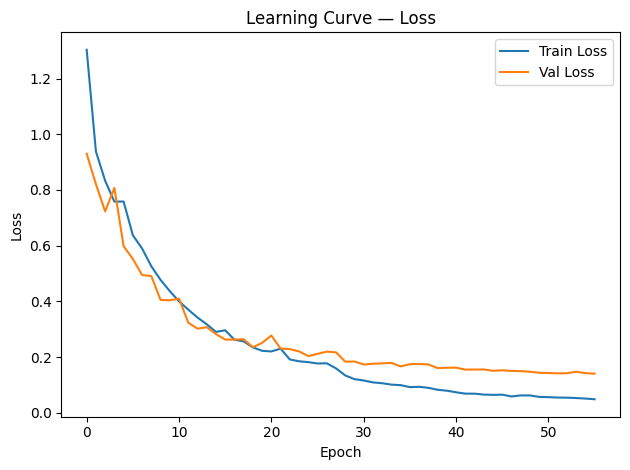

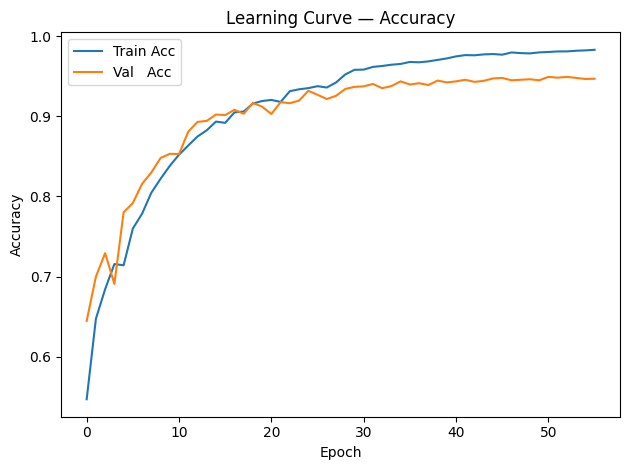

In [29]:
# Cell 18 – Visualize Learning Curves
with open('history.pkl', 'rb') as f:
    hist = pickle.load(f)

plt.figure()
plt.plot(hist['loss'],      label='Train Loss')
plt.plot(hist['val_loss'],  label='Val Loss')
plt.xlabel('Epoch'); plt.ylabel('Loss')
plt.title('Learning Curve — Loss'); plt.legend(); plt.tight_layout(); plt.show()

plt.figure()
plt.plot(hist['accuracy'],      label='Train Acc')
plt.plot(hist['val_accuracy'],  label='Val   Acc')
plt.xlabel('Epoch'); plt.ylabel('Accuracy')
plt.title('Learning Curve — Accuracy'); plt.legend(); plt.tight_layout(); plt.show()


## 19. Visualize Confusion Matrix

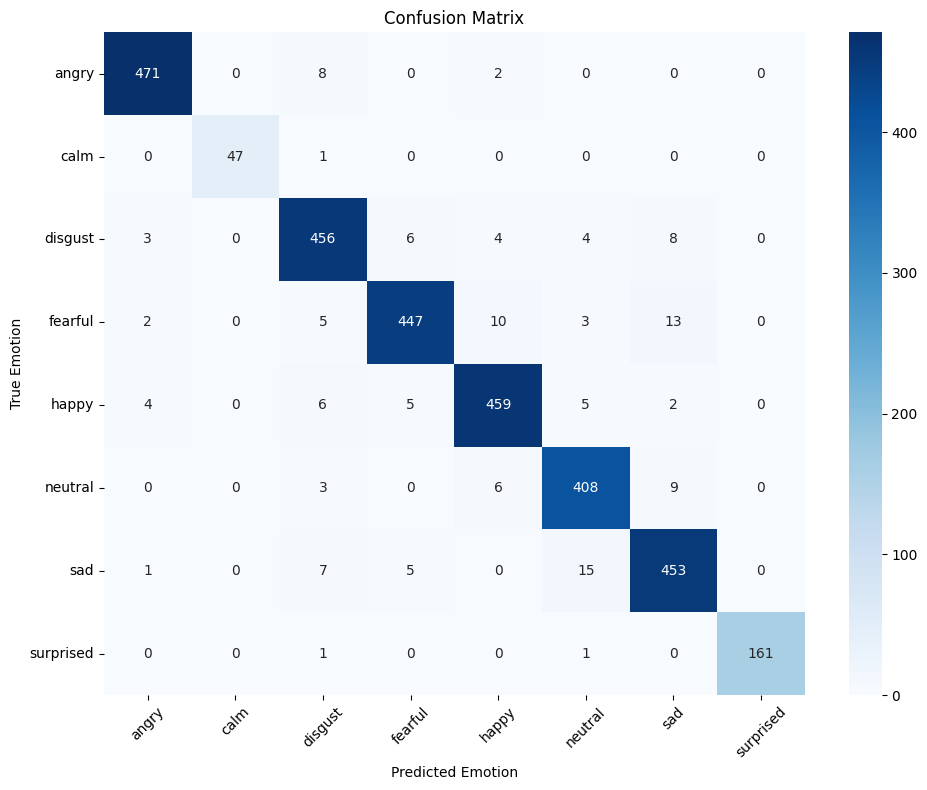

In [30]:
# 1. Build the confusion matrix array
cm = confusion_matrix(y_true, y_pred)
labels = encoder.categories_[0]

# 2. Plot it
plt.figure(figsize=(10,8))
sns.heatmap(
    cm,
    annot=True,         # write the numbers in each cell
    fmt='d',            # integer format
    cmap='Blues',       # blue colour map
    xticklabels=labels, # predicted labels
    yticklabels=labels  # true labels
)
plt.xlabel("Predicted Emotion")
plt.ylabel("True Emotion")
plt.title("Confusion Matrix")
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()
